# Background



Technology has democratized advertising in our society, with influencer marketing emerging as a mainstream form of online marketing. Brands collaborate with popular online influencers to market products or services in order to improve brand recognition among target audiences. Unlike celebrities, influencers in social media can be anyone who has built a reputation for their knowledge and expertise on a specific topic. They are influential due to their large followings on the web which brands take advantage of because they can create trends and encourage their followers to buy products they promote. Influencers have the potential to affect the purchasing decisions of others because of their authority, knowledge, position, or relationship with their audience. 

Despite the results that can be gained through influencer marketing, researching and finding the right influencers is not an easy process. To achieve results and effectively engage the right audience, brands need to identify individuals who can act as genuine brand ambassadors and bring consumers on board with the products and services. Selecting an influencer that fits the brand can help to achieve the engagement and traffic desired. Simply looking at online profiles with the most followers might not satisfy a particular niche for the brands which is why they often spend considerable time finding the right influencers to achieve a good engagement rate with a targeted audience. Determining how different influencers generate traction and engagement rate is important, so that brands can allocate their budget more effectively when looking to sponsor. Thus, the main objective for this project is to examine how information on Instagram posts (captions, comments, sponsorship) and the influencer (category, bio, followers, followees) can be used to determine how popular a post will be. In particular, I also believe that the content of captions accompanying Instagram posts provide important context and are thus important in eliciting likes and shares.


# Dataset Source

The data we are using is collected from Instagram by Seungbae Kim, an assistant professor at University of South Florida for research purposes and was obtained with his consent (Kim et al., 2021):
https://sites.google.com/site/sbkimcv/dataset

This dataset contains information about influencer posts that have association with different brands. There are approximately 1.6 million Instagram posts, 26,910 brand names, and 38,113 different unique influencers in our dataset (Kim et al., 2021). The posts are specifically split into two types of categories: sponsored brand mentions and non-sponsored brand mentions. A sponsored post is one where the influencer gets paid for advertising and mentioning the name of the brand. 

# Text Preprocessing

The original raw data files given to us by Professor Kim comprise multiple JSON and text files. Due to the size of the data, we had to manually extract the information from each file in order to clean, process and merge it all into one big dataset for analysis.

There are approximately 12 GB (3 GB when in zipped format) worth of JSON files containing specific profile and post information. The 1,601,074 JSON files are structured such that each file contains information on 1 profile. Since the number of fields available in each JSON file is not consistent, we extracted relevant fields from the approximately 1.6 million files and compiled them into a single dataset. During this process of compiling the JSON files, we also unpacked the objects within the JSON files and cleaned the dataset. 

For instance, the captions and comments were packed into dictionaries and required unpacking. Notably, the text in the captions or comments were not analyzed in the original paper by the author (Kim et al., 2021). However, the nature of the content can possibly add a useful dimension to the dataset. Thus, we decided to take up the challenge of doing NLP processing of this huge Instagram dataset.

Because we were interested in predicting popular influencers and not the content of comments elicited and also because of the constraint of resources and time, we decided to use only the captions as a feature to predict popularity. Caption content is relevant because it adds to the information of a post’s picture and can elicit strong responses, sharing by viewers and lend context to the post. In addition, only a subset of the JSON posts had comments, thus we decided to focus on the captions.


In [1]:
# import necessary libraries
import nltk
from nltk.corpus import stopwords
import os
import string
import pandas as pd
import numpy as np
import zipfile
import io
import re
from textblob import Word
import math
#from textblob import TextBlob
#from langdetect import detect
import matplotlib.pyplot as plt
import langid
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression, LassoCV, ElasticNetCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from nltk.stem import *
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.ensemble import AdaBoostRegressor

In [2]:
#download stopwords for text analysis later on
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chouche7/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/chouche7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /Users/chouche7/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/chouche7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

### Functions for cleaning text

In [3]:
# create function for punctuation removal:
def remove_punctuations(text):
    for char in string.punctuation:
        text = text.replace(char, '')
    return text

# create function for contraction removal:
def contractions(s):
    s = re.sub(r"won’t", "will not",s)
    s = re.sub(r"would’t", "would not",s)
    s = re.sub(r"could’t", "could not",s)
    s = re.sub(r"\’d", " would",s)
    s = re.sub(r"can\’t", "can not",s)
    s = re.sub(r"n\’t", " not", s)
    s = re.sub(r"\’re", " are", s)
    s = re.sub(r"\’s", " is", s)
    s = re.sub(r"\’ll", " will", s)
    s = re.sub(r"\’t", " not", s)
    s = re.sub(r"\’ve", " have", s)
    s = re.sub(r"\’m", " am", s)
    return s

### Load influencer profile data from multiple sources

In [4]:
#read our data on instagram posts
with open('project_data/post_info.txt') as f:
    lines = f.readlines()

In [5]:
data  = [x.split("\t") for x in lines]

post_df = pd.DataFrame(data, columns = ["post_id", "username", "sponsored", "json_id", "jpg_file"])
post_df = post_df[["post_id", "username", "sponsored", "json_id"]]

post_df["json_id"] = post_df["json_id"].replace(r'.json','', regex=True) 
post_df.head()

,post_id,username,sponsored,json_id
0,0,alisasia,1,1309041812857818435
1,1,alisasia,0,1311846669234786866
2,2,alisasia,0,1315560311952470229
3,3,alisasia,0,1318531733175899446
4,4,alisasia,0,1343280729400051114


In [6]:
#read our data on influencers in a zip file
myzipfile= zipfile.ZipFile('project_data/profiles_influencers.zip')
influ_files = myzipfile.namelist()[1:]

In [7]:
profile_df = []
with zipfile.ZipFile('project_data/profiles_influencers.zip', 'r') as zip:
    for file in influ_files:
        username = file.split("/")[1]
        data = zip.read(file)
        data = io.StringIO(data.decode())
        data  = [x.split("\t") for x in data]
        data = [col for sublist in data for col in sublist if col != "\n"]
        data.insert(0, username)
        profile_df.append(pd.DataFrame([data], columns = ["username", "name", "followers", "followees", "posts", "url", "t/f", "category", "bio", "email", "phone", "profile_pic"]))

profile_df = pd.concat(profile_df, ignore_index = True)
profile_df = profile_df[["username", "name", "followers", "followees", "posts", "url", "category", "bio"]]
profile_df.head()

,username,name,followers,followees,posts,url,category,bio
0,fodmap_friendly_eating,FODMAP Friendly Eating,11299,2609,549,https://fodmapfriendlyeating.wordpress.com/,Creators & Celebrities,Delicious FODMAP Friendly recipes from @antoni...
1,paileaa,paige leanne,12615,1207,1386,https://paileaa.com/2018/10/08/that-last-bit-o...,Creators & Celebrities,London | positive vibes & good times p.goodes...
2,a12team,A12 Team,1319,861,405,http://www.a12.com.pl/,Food & Personal Goods,Photography & Production services 📩 info@a12....
3,ilbulgaro89,Andrea Paesetti,1547,909,1250,http://youtube.com/c/SpazioiTechItalia,Creators & Celebrities,Italian -- #Technology addicted -- Editor & Re...
4,joililikoi,Joie Lee Ruggiero,7427,1836,908,http://wearehaumea.com/retreats,NULL,HI / LA | I seek to inspire and be inspired ...


In [8]:
#merge data on post and influencer into one
posts_influ_df = pd.merge(post_df, profile_df, on="username")

#drop unnecessary columns that won't be used in the model
posts_influ_df = posts_influ_df.filter(items=['sponsored', 'json_id', 'followers', "followees", 'category'])
posts_influ_df.drop_duplicates(subset=['json_id'], inplace = True)
posts_influ_df['json_id']=posts_influ_df['json_id'].astype(int)
posts_influ_df.head()

,sponsored,json_id,followers,followees,category
0,1,1309041812857818435,41099,320,Creators & Celebrities
1,0,1311846669234786866,41099,320,Creators & Celebrities
2,0,1315560311952470229,41099,320,Creators & Celebrities
3,0,1318531733175899446,41099,320,Creators & Celebrities
4,0,1343280729400051114,41099,320,Creators & Celebrities


In [9]:
# define data
posts_influ_df = posts_influ_df.loc[posts_influ_df["category"] != "NULL"]
categorical = posts_influ_df[["category"]]
for col in categorical:    
    # define one hot encoding
    encoder = OneHotEncoder(sparse=False)
    # transform data
    cat = np.array(categorical[col]).reshape(-1, 1)
    onehot = encoder.fit_transform(cat)
    onehot = pd.DataFrame(onehot)
    onehot.columns = col + "_" + encoder.get_feature_names_out()
    onehot.columns = [x.replace(r'_x0','') for x in onehot.columns]
    posts_influ_df = pd.concat([posts_influ_df, onehot], axis=1, join='inner')
    posts_influ_df = posts_influ_df.loc[:, posts_influ_df.columns != col]
posts_influ_df.head()

,sponsored,json_id,followers,followees,category_Auto Dealers,category_Business & Utility Services,category_Content & Apps,category_Creators & Celebrities,category_Entities,category_Food & Personal Goods,...,category_Home Goods Stores,category_Home Services,category_Lifestyle Services,category_Local Events,category_Non-Profits & Religious Organizations,category_Personal Goods & General Merchandise Stores,category_Professional Services,category_Publishers,category_Restaurants,category_Transportation & Accomodation Services
0,1,1309041812857818435,41099,320,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,1311846669234786866,41099,320,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,1315560311952470229,41099,320,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,1318531733175899446,41099,320,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,1343280729400051114,41099,320,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Load information about posts

In [10]:
#read data regarding captions of the posts
#df1 = pd.read_excel('project_data/output_df1_first65000.xlsx')

# load the cleaned Captions file, where the dictionaries are unpacked and the '/n' are removed.
df1 = pd.read_csv("project_data/compiled_jsons_all_Captions_unnested_2.csv")

df1.head()

,Unnamed: 0.1,Unnamed: 0,id,Captions
0,0,0,1000013365102810365,"['#Regram from @lucavezil: ""You know why I lov..."
1,1,1,1000043359370989848,['Our society today is so desensitized to porn...
2,2,2,1000055615134224232,['brought out my cute lil @benefitcosmetics pa...
3,3,3,1000084729422320243,['How about Sweet Potato Pear and Broccoli by ...
4,4,4,1000147795992383306,"['In the end, we only regret the chances we di..."


In [11]:
# dataset is too big and we are going to sample 50% of it at random
df1_sampled = df1.sample(math.floor(df1.shape[0] * 0.1), random_state = 0)
df1_sampled.drop_duplicates(subset=['id'], inplace = True)
df1_sampled.shape

(137579, 4)

In [12]:
df1_sampled = df1_sampled.iloc[:,2:]
df1_sampled = df1_sampled.rename(columns={"id": "json_id", "Captions": "caption"})
df1_sampled = df1_sampled.loc[df1_sampled["caption"].isnull() != True ]
df1_sampled = df1_sampled.loc[df1_sampled["caption"] != None]

### Clean captions (stemming, lemmatization, stop words removal) for NLP analysis using TF-IDF


Bag-of-words model was used as a tool of feature generation for the captions. After transforming the text of captions into a bag-of-words, we performed the calculation of term frequency, which refers to the number of times a term appears in the text. Term frequency (TF) might not be the best representation of the text because the common words like ‘the’,’a’,’is’ are most likely to be the highest frequency terms. Thus, to address this problem, the term frequency was converted into term frequency-inverse document frequency (TF-IDF). The reason we need IDF is to minimize the weighting of common terms while making infrequent terms have a higher impact. Putting both together, the TF-IDF score tells how important and relevant a term is. 

Then, we performed sentiment analysis on the text of comments to tag the comments as “positive”, “neutral” and “negative”. This will add a useful feature of popularity in addition to the number of likes and comments a post garners. While we initially planned to create our own sentiment analysis model using the TF-IDF results and compare with some pre-trained models, the sheer volume of the data meant that we were unable to complete some steps because of the limitations of our systems’ computing power. 


In [13]:
#clean the captions by removing punctuations, lower casing, and removing stop words
df1_sampled["caption"] = df1_sampled["caption"].str.lower()
df1_sampled["caption"] = df1_sampled["caption"].apply(lambda x: re.sub(r'@\w+', "", x))
df1_sampled["caption"] = df1_sampled["caption"].apply(remove_punctuations)

stop = stopwords.words('english')
df1_sampled["caption"] = df1_sampled["caption"].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))
#df1["caption"] = df1["caption"].apply(lambda x: x.encode('ascii', 'ignore').decode('ascii'))

In [14]:

df1_sampled["caption"]=df1_sampled["caption"].apply(lambda x:contractions(x))
df1_sampled["caption"]=df1_sampled["caption"].apply(lambda x: re.sub(' +', ' ', x))


In [15]:
#utilize the textblob package to edit wrong words
#df1["caption"] = df1["caption"].apply(lambda x: TextBlob(x).correct())

In [16]:
df1_sampled = df1_sampled.loc[df1_sampled["caption"].isnull() != True ]
df1_sampled = df1_sampled.loc[df1_sampled["caption"] != None]

In [17]:
#keep only the stem of every word
lemmatizer = WordNetLemmatizer()
df1_sampled["caption"] = df1_sampled["caption"].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
df1_sampled["caption"].head()

814850     rientro casa spero di tornare presto nella bel...
326085     guest room looking like modge podge it is walk...
1021728    obsessed unicorn tee use discount code ‘chloe9...
323065     ragazze vi ricordo di nuovo della promozione s...
869097     friday vid shortly focusing around bare necess...
Name: caption, dtype: object

In [18]:
#remove non english words
words = set(nltk.corpus.words.words())

df1_sampled["caption"] = df1_sampled["caption"].apply(lambda x: " ".join([word for word in x.split() \
         if word in words]))

#df1["caption"] = df1["caption"].apply(lambda x: " ".join(x.split()))
    
df1_sampled["caption"].head()

814850                    di presto di un che mi ha di con e
326085     guest room looking like podge it is walkable p...
1021728    unicorn tee use discount code save teen unicor...
323065     di di di la neon che di e sulla e link story n...
869097                 shortly around bare necessity palette
Name: caption, dtype: object

In [19]:
# analyze what language each caption is
df1_sampled["lang"] = df1_sampled["caption"].apply(lambda x: langid.classify(x)[0])


In [20]:
#remove captions that aren't english
df1_sampled = df1_sampled.loc[df1_sampled["lang"] == "en"]
df1_sampled.head()

,json_id,caption,lang
326085,1700130069736603012,guest room looking like podge it is walkable p...,en
1021728,1638662219070667027,unicorn tee use discount code save teen unicor...,en
869097,1462606516766142856,shortly around bare necessity palette,en
467336,1459009717292338546,past couple day fun much wish could fit one post,en
100785,1517839551120552138,best time chatting elle today lunch always gre...,en


In [21]:
# TF-IDF

#Convert a collection of text documents to a matrix of token counts (for each word)
tfidfconverter = TfidfVectorizer(max_features = 500, min_df= 100, max_df=0.7, stop_words=stopwords.words('english'))  
tf_idf_vector = tfidfconverter.fit_transform(df1_sampled["caption"]).toarray()
feature_names = tfidfconverter.get_feature_names_out()

print(tf_idf_vector.shape)
#show an example of the first document tf_idf breakdown
first_document_vector=tf_idf_vector[1]
df_tfifd= pd.DataFrame(first_document_vector, index=feature_names, columns=["tfidf"])
df_tfifd.sort_values(by=["tfidf"],ascending=False)


(108128, 500)


,tfidf
discount,0.714920
save,0.375638
model,0.350085
girl,0.302189
code,0.259631
...,...
flower,0.000000
flavor,0.000000
fitness,0.000000
fit,0.000000


In [22]:
#tf_idf = TfidfVectorizer()
#word_vectors = tf_idf.fit_transform(df1_sampled["caption"])
df1_sampled.reset_index(drop=True, inplace=True)
word_vectors = pd.DataFrame(tf_idf_vector, columns = feature_names)
final_data = pd.concat([df1_sampled["json_id"], word_vectors], axis=1)

final_data.head()

,json_id,able,absolutely,accessory,actually,ad,add,adventure,ago,almond,...,workout,world,worth,would,year,yes,yesterday,yet,yoga,yummy
0,1700130069736603012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1638662219070667027,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1462606516766142856,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1459009717292338546,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1517839551120552138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
#df1_sampled.rename(columns={ df1_sampled.columns[0]: "json_id" }, inplace = True)

final_data = final_data.merge(posts_influ_df, how='inner', on= "json_id")
final_data.head()

,json_id,able,absolutely,accessory,actually,ad,add,adventure,ago,almond,...,category_Home Goods Stores,category_Home Services,category_Lifestyle Services,category_Local Events,category_Non-Profits & Religious Organizations,category_Personal Goods & General Merchandise Stores,category_Professional Services,category_Publishers,category_Restaurants,category_Transportation & Accomodation Services
0,1700130069736603012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1638662219070667027,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1462606516766142856,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1459009717292338546,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1517839551120552138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
final_data.shape

(83189, 525)

In [25]:
first = pd.read_csv("project_data/compiled_jsons_0_400000_trimmed.csv")
second = pd.read_csv("project_data/compiled_jsons_400000_800000_trimmed.csv")
third = pd.read_csv("project_data/compiled_jsons_800000_1200000_trimmed.csv")
fourth = pd.read_csv("project_data/compiled_jsons_1200001_1601074_trimmed.csv")
first.head()

/var/folders/b3/2c5nrf8s3k3f2z_yxv6vpz340000gn/T/ipykernel_5934/1567730900.py:1: DtypeWarning: Columns (8,9,10,11,12,13,14,15,16,17,18,19,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  first = pd.read_csv("project_data/compiled_jsons_0_400000_trimmed.csv")
/var/folders/b3/2c5nrf8s3k3f2z_yxv6vpz340000gn/T/ipykernel_5934/1567730900.py:4: DtypeWarning: Columns (22,23,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  fourth = pd.read_csv("project_data/compiled_jsons_1200001_1601074_trimmed.csv")


,Unnamed: 0,id,is_video,taken_at_timestamp,edge_media_preview_like_count,edge_media_to_caption_edges,edge_media_to_comment_count,owner_id,is_ad,viewer_can_reshare,...,viewer_has_saved_to_collection,viewer_in_photo_of_you,edge_media_preview_like_edges,edge_media_to_comment_edges,edge_media_to_comment_page_info_end_cursor,edge_media_to_comment_page_info_has_next_page,edge_media_to_sponsor_user_edges,edge_media_to_tagged_user_edges,edge_web_media_to_related_media_edges,owner_username
0,0,1000013365102810365,False,1433430904,3390,"[{'node': {'text': '#Regram from @lucavezil: ""...",26,222106572,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1000043359370989848,False,1433434480,125,[{'node': {'text': 'Our society today is so de...,5,237634851,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1000055615134224232,False,1433435941,22652,[{'node': {'text': 'brought out my cute lil @b...,62,19538442,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1000084729422320243,False,1433439411,272,[{'node': {'text': 'How about Sweet Potato Pea...,28,1431250163,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1000147795992383306,False,1433446929,7407,"[{'node': {'text': ""In the end, we only regret...",33,258280258,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
first = first[["id", "edge_media_preview_like_count"]]
second = second[["id", "edge_media_preview_like_count"]]
third = third[["id", "edge_media_preview_like_count"]]
fourth = fourth[["id", "edge_media_preview_like_count"]]

likes = pd.concat([first, second, third, fourth], axis = 0)
likes = likes.rename(columns={"id": "json_id", "edge_media_preview_like_count": "likes_per_follower"})

In [27]:
final_data = final_data.merge(likes, how = "left", on= "json_id")
final_data["followers"] = final_data["followers"].astype(int)
final_data["likes_per_follower"] = final_data["likes_per_follower"]/final_data["followers"]
final_data.head()

,json_id,able,absolutely,accessory,actually,ad,add,adventure,ago,almond,...,category_Home Services,category_Lifestyle Services,category_Local Events,category_Non-Profits & Religious Organizations,category_Personal Goods & General Merchandise Stores,category_Professional Services,category_Publishers,category_Restaurants,category_Transportation & Accomodation Services,likes_per_follower
0,1700130069736603012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.046147
1,1638662219070667027,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.101312
2,1462606516766142856,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.036242
3,1459009717292338546,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.012755
4,1517839551120552138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008871


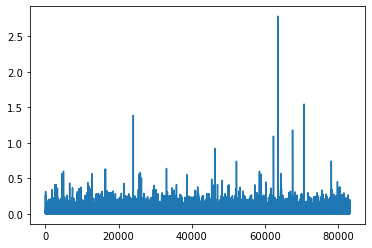

In [28]:
plt.plot(final_data["likes_per_follower"])

In [29]:
final_data = final_data.drop(["json_id","followers", "followees"], axis = 1)

# Model Building

### Linear Regression

In [30]:

X = final_data.loc[:, final_data.columns != "likes_per_follower"]
Y = final_data["likes_per_follower"]


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .30, random_state = 0)
cv = KFold(n_splits=5, random_state=0, shuffle=True)

reg = LinearRegression().fit(X_train, Y_train)
reg.score(X_train, Y_train)

0.03163805716780055

In [31]:
y_pred=reg.predict(X_train)

In [32]:
rmse = math.sqrt(mean_squared_error(Y_train, y_pred))
print("Training RMSE of the model is %.4f" %rmse)

Training RMSE of the model is 0.0360


In [33]:
scores = cross_val_score(reg, X_train, Y_train, scoring='neg_root_mean_squared_error',
                         cv=cv, n_jobs=-1)

print("Validation RMSE of the model is %.4f" %np.mean(np.absolute(scores)))

Validation RMSE of the model is 56622376.7727


In [34]:
#add constant to predictor variables
x = sm.add_constant(X_train)

#fit linear regression model
model = sm.OLS(np.asarray(Y_train, dtype=float), np.asarray(x, dtype=float)).fit() 

#create instance of influence
influence = model.get_influence()

#obtain Cook's distance for each observation
cooks = influence.cooks_distance[0]

#display Cook's distances
print(cooks)

[3.05618013e-06 9.34418606e-06 4.75133425e-07 ... 6.86075525e-06
 1.09126231e-05 7.89666446e-06]


/Users/chouche7/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:696: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)


In [35]:
X_train_cooks = X_train.loc[cooks < (4/len(cooks))]
y_train_cooks = Y_train.loc[cooks < (4/len(cooks))]

In [36]:
reg = LinearRegression().fit(X_train_cooks, y_train_cooks)
reg.score(X_train_cooks, y_train_cooks)

0.04671430217744965

In [37]:
y_pred=reg.predict(X_train_cooks)

In [38]:
rmse = math.sqrt(mean_squared_error(y_train_cooks, y_pred))
print("Training RMSE of the model is %.4f" %rmse)

Training RMSE of the model is 0.0231


In [39]:
scores = cross_val_score(reg, X_train_cooks, y_train_cooks, scoring='neg_root_mean_squared_error',
                         cv=cv, n_jobs=-1)

#view RMSE (validation error)
print("Validation RMSE of the model is %.4f" %np.mean(np.absolute(scores)))

Validation RMSE of the model is 0.0233


### LASSO

The LASSO penalization model is used because we have over 100 predictors (due to the bag of words creating new features for each word) and LASSO is known to penalize the model for unnecessary features which will help us narrow down the important factors. Not only does it control model complexity and variable selection, it also encourages sparsity in solution


In [40]:
lasso = LassoCV(cv=5, random_state=0).fit(X_train_cooks, y_train_cooks)

In [41]:
lasso_features = lasso.feature_names_in_[lasso.coef_ != 0]

In [42]:
lasso_features.shape

(399,)

In [43]:
X = X_train_cooks.loc[:, X_train_cooks.columns.isin(lasso_features)]
#Y = final_data["likes_per_follower"]


#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .30, random_state = 0)
lasso = LinearRegression().fit(X, y_train_cooks)
lasso.score(X, y_train_cooks)

0.04642132830608614

In [44]:
y_pred=lasso.predict(X)

rmse = math.sqrt(mean_squared_error(y_train_cooks, y_pred))
print("Training RMSE of the model is %.4f" %rmse)

Training RMSE of the model is 0.0231


In [45]:
scores = cross_val_score(lasso, X, y_train_cooks, scoring='neg_root_mean_squared_error',
                         cv=cv, n_jobs=-1)

print("Validation RMSE of the model is %.4f" %np.mean(np.absolute(scores)))

Validation RMSE of the model is 0.0232


### AdaBoost

The AdaBoost model builds on top of the previous models’ error in order to create one effective model. Boosting is generally better than bagging (random forest) when the classifier is stable and simple (high bias) whereas bagging is better when there is high variance (overfitting).

One thing to note is that boosting algorithms are extremely sensitive to outliers. This is because every classifier works off of the errors of its predecessors, so every model is forced to learn even the “bad” data. To prevent this from occurring, we made our best attempt in removing outliers by applying Cook’s Distance first to a multiple linear regression model. Cook’s Distance is measured by the difference in fitted values when the specific datum point is removed from the model; hence, data that shift our output values greatly will have a large distance (to be removed). Usually, this method only applies to the least-squares method, but due to time constraints, we used it to look for highly influential points for both the LASSO and AdaBoost models.

In [46]:
for depth in range (3,10):
    tree_classifier=tree.DecisionTreeRegressor(max_depth=depth,random_state=0)
    tree_classifier.fit(X, y_train_cooks)
    score=np.mean(np.absolute(cross_val_score(tree_classifier,X, y_train_cooks,scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)))
    print(depth, score)

3 0.023568819509251066
4 0.023557848408126046
5 0.023564325294690706
6 0.023555867026240077
7 0.02358850321988025
8 0.023613974999732966
9 0.023643904690984336


In [47]:
#HYPER-PARAMETER TUNING for number of trees and learning rate
#this takes a couple hours to run
#don't run this unless the data has changed

#ada=AdaBoostRegressor(base_estimator=tree.DecisionTreeRegressor(max_depth=6,random_state=0))
#search_grid={'n_estimators':[100,300,500],'learning_rate':[.01,0.1,1]}
#ada_clf=GridSearchCV(estimator=ada,param_grid=search_grid,scoring='neg_root_mean_squared_error', cv=cv, return_train_score = True)
#ada_clf.fit(X, y_train_cooks)
#ada_clf.best_params_

In [48]:
ada_clf=AdaBoostRegressor(base_estimator=tree.DecisionTreeRegressor(max_depth=6,random_state=0), n_estimators = 100, learning_rate = 0.01, random_state=0)
ada_clf.fit(X, y_train_cooks)

y_pred=ada_clf.predict(X)

rmse = math.sqrt(mean_squared_error(y_train_cooks, y_pred))
print("Training RMSE of the model is %.4f" %rmse)

Training RMSE of the model is 0.0235


In [49]:
#print("Validation RMSE of the model is %.4f" %np.mean(np.absolute(ada_clf.best_score_)))
scores = cross_val_score(ada_clf, X, y_train_cooks, scoring='neg_root_mean_squared_error',
                         cv=cv, n_jobs=-1)

print("Validation RMSE of the model is %.4f" %np.mean(np.absolute(scores)))

Validation RMSE of the model is 0.0235


# Model Valuation on Testing Data (based on the lowest validation error)

In [50]:
X_test_reduced = X_test.loc[:, X_test.columns.isin(lasso_features)]

In [51]:
y_pred = lasso.predict(X_test_reduced)

rmse = np.sqrt(mean_squared_error(Y_test,y_pred))
print("Test RMSE of the LASSO model is %.6f" %rmse)


Test RMSE of the LASSO model is 0.035264


In [52]:
y_pred = ada_clf.predict(X_test_reduced)

rmse = np.sqrt(mean_squared_error(Y_test,y_pred))
print("Test RMSE of the AdaBoost model is %.6f" %rmse)


Test RMSE of the AdaBoost model is 0.035387


Through the results, it is clear that both the multiple linear regression with LASSO feature selection and AdaBoost perform similarly. According to the top 10 largest positive coefficients based on LASSO feature selection for linear regression, the word "topped" improves likes the most. As a stand alone word, it seems like "topped" doesn't really mean a whole lot; however, if we look at the posts using this word, we can understand that it is commonly used in posts related to foods.

Similarly, words such as ‘concealer’ and 'glass' standout in particular as they seem to describe posts about makeup and female beauty which have a positive coefficient, implying an increase in likes per follower. On the other hand, people seem to dislike government agency pages and people who repost other contents since they negatively impact the popularity of the post. 


In [53]:
# show all the words that have the most impact both negative and positive
lasso.feature_names_in_[np.argsort(np.absolute(lasso.coef_))[::-1]][:10]

array(['category_Government Agencies', 'topped', 'repost', 'via', 'spray',
       'goody', 'available', 'code', 'along', 'care'], dtype=object)

In [54]:
# their coefficients
lasso.coef_[np.argsort(np.absolute(lasso.coef_))[::-1]][:10]

array([-0.02401311,  0.01895701, -0.01768584, -0.01483679, -0.01295867,
       -0.01295056, -0.01250657,  0.01199496, -0.01170395, -0.01164219])

In [55]:
# show only the words that have a positive impacts on likes
lasso.feature_names_in_[np.argsort(lasso.coef_)[::-1]][:10]

array(['topped', 'code', 'concealer', 'inspiration', 'adventure', 'gloss',
       'also', 'might', 'outfit', 'city'], dtype=object)

In [56]:
# their coefficients
lasso.coef_[np.argsort(lasso.coef_)[::-1]][:10]

array([0.01895701, 0.01199496, 0.01117251, 0.00945354, 0.00925197,
       0.00917202, 0.0090462 , 0.00891303, 0.00816344, 0.00812252])

In [57]:
topped = df1["Captions"].loc[df1["Captions"].str.contains(" topped ") & ~df1["Captions"].isnull()]
topped.iloc[0]

"['*advertisement For me watchin @originaldiaries and eating some delicious waffles is the perfekt start in the day ❤️ ❔What is your perfekt start in the day❔  I topped my waffles with some fresh strawberries 🍓 , mango 🍈 and a ', 'little bit', ' nutella 🍫😅 Ingredients for 2 LOW CARB WAFFLES 🍓🍓: 1⃣ 2 beaten egg whites (2 steif geschlagene Eiweiße) 🍳 2⃣ 1 egg yolk (1 Eigelb) 🍳 3⃣ 60g protein powder (Ich habe @fitnessguru ', 's OnePancake verwendet) 🌾 4⃣ 30g almond flour (30g Mandelmehl) 4⃣ 7g baking powder (7g Backpulver) 5⃣ 50 - 100ml milk of your choice (50 - 100ml Milch nach Wahl) 🍼 6⃣ 1 teaspoon coconut- or other healthy oil (1 Teelöffel Kokosnuss- oder anderes gesunde Öl)  Directions (Anleitung): 1⃣ Combine all ingredients in a bowl and mix them well (Vermische alle Zutaten gut in einer Schüssel) 🍶 2⃣ Grease waffle iron with a tiny bit oil and turn it on (Waffeleisen etwas einölen und einschalten) 3⃣ Bake waffle until done (Waffel backen bis sie fertig ist) 💜 {the recipe is from lov

In [58]:
topped.iloc[3]

"['Perfect banana pancakes topped with @fiveamorganics Greek yogurt and berries galore. Happy Thursday everyone ❤️ #wakeupbeamazing']"

In [59]:
topped.iloc[5]

"['🌿 mixed my @diginn into one bowl for a tasty broccoli/roasted garlic + roasted sweet potato brown rice bowl topped with fresh guac!']"

In [60]:
index = np.where(ada_clf.feature_importances_ != 0)

In [61]:
tree_importance = ada_clf.feature_names_in_[index]
tree_importance

array(['able', 'ad', 'add', 'adventure', 'ago', 'also', 'always',
       'amazing', 'anything', 'art', 'available', 'away', 'awesome',
       'baby', 'bag', 'banana', 'bar', 'beach', 'beauty', 'believe',
       'best', 'big', 'birthday', 'black', 'blue', 'blush', 'book',
       'boot', 'bowl', 'box', 'break', 'breakfast', 'bring', 'brow',
       'brown', 'brush', 'butter', 'care', 'celebrate', 'chance',
       'change', 'check', 'cheese', 'chicken', 'chocolate', 'city',
       'classic', 'clean', 'coat', 'coconut', 'code', 'coffee', 'cold',
       'collection', 'color', 'come', 'coming', 'comment', 'concealer',
       'contest', 'cool', 'cosmetic', 'could', 'course', 'cozy', 'cream',
       'cup', 'currently', 'daily', 'dark', 'date', 'day', 'delicious',
       'design', 'detail', 'dip', 'dog', 'done', 'dress', 'early', 'easy',
       'eat', 'else', 'end', 'enough', 'enter', 'especially', 'event',
       'ever', 'every', 'everyone', 'everything', 'excited', 'eye',
       'face', 'fall'

Feature importance is calculated in regression trees based on the total reduction of a criterion (squared error) brought by that feature. Words like ‘new’, ‘link’, ‘code’, and ‘profile’ are all common terms that influencers use when they want to sell you certain items with their affiliate code or link. These tend to work well with the instagram audience which is why sponsors are always looking for new influencers to help them promote their products via this method, while terms like “recipe”, “outfit”, and “vacation” tend to be more about influencers just expressing themselves such as what they are cook, wearing or where they are traveling to. It is also not surprising to see that the category of creators and celebrities has the highest impact out of all categories as it is the most popular. 

If we can compare the words between LASSO and AdaBoost, we see that the two overlapping words are code and outfit which clearly shows the importance of discounts when promoting items for brands. These affiliate codes and links seem to draw people into whatever content the influencer is posting especially topics related to fashion and dressing up. 

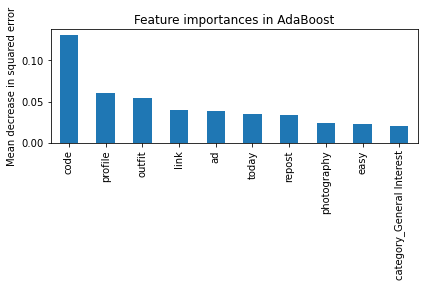

In [62]:
# The higher, the more important the feature. 
# The importance of a feature is computed as the (normalized) 
# total reduction of the criterion (squared error) brought by that feature. 
mse_decrease = ada_clf.feature_importances_[index][np.argsort(ada_clf.feature_importances_[index])[::-1]][:10]
forest_importances = pd.Series(mse_decrease, index=ada_clf.feature_names_in_[index][np.argsort(ada_clf.feature_importances_[index])[::-1]][:10])

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances in AdaBoost")
ax.set_ylabel("Mean decrease in squared error")
fig.tight_layout()


In [64]:
ada_clf.estimator_errors_

array([0.06035044, 0.06029693, 0.06028445, 0.06061092, 0.06092264,
       0.06064923, 0.06089854, 0.06086269, 0.06091294, 0.06097958,
       0.06124679, 0.06141657, 0.06130026, 0.06137198, 0.06157587,
       0.06147531, 0.06159308, 0.06165732, 0.06163478, 0.06210695,
       0.06215735, 0.06226424, 0.06216779, 0.06237525, 0.06243034,
       0.06238229, 0.06237173, 0.06276915, 0.06288014, 0.06303206,
       0.06302879, 0.06322112, 0.06317143, 0.0632118 , 0.06349389,
       0.06341445, 0.06348203, 0.06371329, 0.06353856, 0.06378691,
       0.06380726, 0.06408535, 0.06417211, 0.06439591, 0.06425317,
       0.06451321, 0.06478981, 0.06450151, 0.06462852, 0.0647791 ,
       0.06476649, 0.0650247 , 0.06491211, 0.06513345, 0.06554105,
       0.06522073, 0.0655232 , 0.06553835, 0.06568853, 0.06545682,
       0.06561291, 0.06613428, 0.06611781, 0.06589113, 0.06612081,
       0.06642567, 0.06668298, 0.06656787, 0.06632128, 0.06678802,
       0.06670051, 0.06701908, 0.06695441, 0.0672713 , 0.06742

In [65]:
#look at some captions with the top words
codes = df1["Captions"].loc[df1["Captions"].str.contains("code") & ~df1["Captions"].isnull()]
profile = df1["Captions"].loc[df1["Captions"].str.contains("profile") & ~df1["Captions"].isnull()]
outfit = df1["Captions"].loc[df1["Captions"].str.contains("outfit") & ~df1["Captions"].isnull()]

In [66]:
codes.iloc[0]

"['incredibly excited to announce my partnership with @rocksbox this summer! start your summer off right and use promo code gracearagonxoxo to get 1 month free and enjoy your own beautiful, designer jewelry! #RBItGirl #Rocksbox']"

In [67]:
profile.iloc[0]

"['Everything you need to make cornmeal and spelt pancakes and rhubarb whipped cream! Find the recipe and 🌟🌟enter to win a @rudehealth Ultimate Breakfast Hamper! 🌟🌟 .  On the blog, www.theworktop.com, link in profile. . #feedfeed #breakfast #foodporn #pancakes #giveaway #rhubarb #instafood #healthy #spelt #f52grams #foodie #pancake #competition #sunday #delicious #speltflour #homemade #foodphotography #eatclean #vscocam #cleaneating']"

In [68]:
outfit.iloc[0]

"['I feel aroused in me an interior decorator soul. Planted in the decor, for @dockerseurope contest, here is my outfit. With a blue chino alpha khaki and grey jacket from @dockerskhakis . Don', 't forget to add me on Snapchat for more live events #dockersonthego']"

# Conclusion

In summary, we have successfully used NLP analysis of a huge dataset of captions as a feature in predicting popularity of influencers. Certain words increase the popularity of the post and provide more traction to the influencer while other contents could prove to be detrimental. 

For future work and given more resources for processing huge datasets, it will be insightful to also analyze the contents of comments elicited as a possible predictor (or indicator) of popularity. Although the TF-IDF scores on the captions have proven to be somewhat lackluster in terms of prediction strength, it has helped explain some of the most prominent words used on Instagram. More NLP models should be considered in the future especially those that can provide semantic understanding of text.

Given the scarcity of Instagram-trained models for captions or comments, I also believe that it will be helpful to contribute to the field by creating our own instagram-trained model and compare to other existing Twitter or general purpose models, so that more businesses and social media users can benefit from our research.
